In [1]:
import pandas as pd
learn_data=pd.read_csv("learn_data.csv") #读取处理好的数据
learn_data.groupby(["0"]).count() #查看每种算法最好时适用于多少种情况

,Unnamed: 0,file,per_request,sequential,requests_byte,inter_time
0,,,,,,
mlf,93,93,93,93,93,93
sjf,2722,2722,2722,2722,2722,2722
to,240,240,240,240,240,240
twins,70,70,70,70,70,70


In [2]:
#sklearn不能处理非数字，先转换一下
target_list=learn_data["0"].unique().tolist()
learn_data["0"] = learn_data["0"].apply(lambda x: target_list.index(x)) #用列表下标代替对应的字符
learn_data.groupby(["0"]).count() #查看每种算法最好时适用于多少种情况

,Unnamed: 0,file,per_request,sequential,requests_byte,inter_time
0,,,,,,
0,2722,2722,2722,2722,2722,2722
1,240,240,240,240,240,240
2,70,70,70,70,70,70
3,93,93,93,93,93,93


In [3]:
#另一种处理方法，内置的labelencoder
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()#将mlf、sjf转化成0、1数字
# learn_data["0"] = labelencoder.fit_transform(learn_data["0"])
# learn_data
# learn_data.groupby(["0"]).count() #['sjf', 'to', 'twins', 'mlf']对应0123

In [4]:
X_data=learn_data[["file","per_request","sequential","requests_byte","inter_time"]]
y_data=learn_data["0"]

from sklearn.preprocessing import StandardScaler
scaler_x=StandardScaler()

X_data=scaler_x.fit_transform(X_data) #标准化，把2000缩放一下

In [5]:
from sklearn.model_selection import train_test_split #划分训练集和测试集

X_train,X_test,y_train,y_test=train_test_split(X_data,y_data,test_size=0.3)

In [6]:
X_train

array([[ 0.        , -0.95320625,  0.        ,  1.94428691, -0.56622936],
       [ 0.        , -0.95320625,  0.        , -0.69571928, -0.56622936],
       [-1.21716124, -0.95320625,  1.41421356, -0.66466038, -0.56622936],
       ...,
       [ 0.        ,  1.79642716,  0.70710678, -0.69571928,  1.99078685],
       [ 1.52145155, -0.76989735, -1.41421356, -0.5404248 , -0.56622936],
       [ 1.52145155, -0.76989735, -1.41421356, -0.04348245, -0.56853297]])

In [7]:
X_test

array([[-0.91287093, -0.40327957, -1.41421356, -0.66466038, -0.56622936],
       [-1.21716124, -0.40327957, -1.41421356, -0.04348245, -0.56853297],
       [-1.21716124,  1.79642716,  0.70710678, -0.04348245, -0.56853297],
       ...,
       [ 1.52145155, -0.76989735, -0.70710678, -0.66466038, -0.31283135],
       [ 0.        ,  0.32995601,  0.70710678,  1.94428691,  1.99078685],
       [-0.91287093,  1.79642716,  0.70710678, -0.66466038, -0.31283135]])

In [8]:
y_train

1321    0
1301    0
106     0
255     0
1838    0
       ..
1347    1
776     0
1829    0
2636    0
2640    0
Name: 0, Length: 2187, dtype: int64

In [9]:
y_test

881     0
265     0
590     0
669     0
25      0
       ..
1875    3
1943    0
2658    3
1724    0
1208    0
Name: 0, Length: 938, dtype: int64

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split #划分训练集和测试集

X_train,X_test,y_train,y_test=train_test_split(X_data,y_data,test_size=0.3)

clf=DecisionTreeClassifier(random_state=0) #随机种子
clf=clf.fit(X_train,y_train)
score_c=clf.score(X_test,y_test)

print("tree:",score_c)

tree: 0.8059701492537313


In [11]:
from sklearn import tree
dot_data = tree.export_graphviz(clf, out_file="Tree_clf.dot" #graphviz结果保存一下
                           ,feature_names=["file","per_request","sequential","requests_byte","inter_time"]
                           ,class_names=['sjf', 'to', 'twins', 'mlf'] #对应0123
                           ,filled=True #决策树节点是否显示颜色，颜色越深分类越明确
                           ,rounded=True #决策树节点的方框是圆的还是方的,
                          )

0.8719701730132797 3


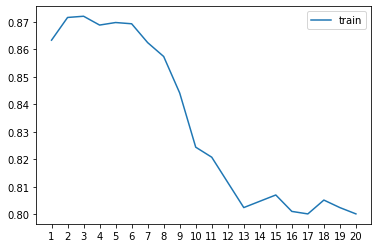

In [12]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

score_list= []
for i in range(20):
    clf = DecisionTreeClassifier(max_depth=i+1) #用不同的决策树深度看一下效果
    score=cross_val_score(clf,X_train,y_train,cv=10).mean()
    score_list.append(score)
    
print(max(score_list),score_list.index(max(score_list))+1)
plt.plot(range(1,21),score_list,label="train")
plt.xticks(range(1,21))
plt.legend()
plt.show() #在深度较浅时能获得最好的结果，大概在5或6比较好

In [13]:
from sklearn.model_selection import GridSearchCV
import numpy as np
gini_thresholds = np.linspace(0,0.5,20)

parameters = {'splitter':('best','random') #使用网格搜索获取最好分类时的参数
              ,'criterion':("gini","entropy")
              ,"max_depth":[*range(3,10)] #大概在5-6比较好，不过可以多搜索一下左右的结果
              ,'min_samples_leaf':[*range(1,50,5)]
              ,'min_impurity_decrease':[*np.linspace(0,0.5,20)]
             }

clf = DecisionTreeClassifier()
GS = GridSearchCV(clf, parameters, cv=10)
GS.fit(X_train,y_train)

print(GS.best_params_) #准确率最高时的参数
print(GS.best_score_) #准确率最高时的分数

{'criterion': 'entropy', 'max_depth': 9, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 11, 'splitter': 'random'}
0.8779188136232248


In [14]:
final_model = DecisionTreeClassifier(max_depth=GS.best_params_["max_depth"]
                                     ,criterion=GS.best_params_["criterion"]
                                     ,min_impurity_decrease=GS.best_params_["min_impurity_decrease"]
                                     ,min_samples_leaf=GS.best_params_["min_samples_leaf"]
                                     ,splitter=GS.best_params_["splitter"]
                                    )
final_model.fit(X_train,y_train)
final_model.score(X_test,y_test) #用最高准确率的参数再测试一下

0.8805970149253731

In [15]:
for feature,importance in zip(["file","per_request","sequential","requests_byte","inter_time"],final_model.feature_importances_):
    print(feature,importance) #查看每种变量对结果的影响，没有超多30%的

file 0.2353360906995403
per_request 0.25573909727094607
sequential 0.11317270207968973
requests_byte 0.10159866169699228
inter_time 0.29415344825283163


In [16]:
from sklearn import tree
dot_data = tree.export_graphviz(final_model, out_file="Tree.dot" #graphviz结果保存一下
                           ,feature_names=["file","per_request","sequential","requests_byte","inter_time"]
                           ,class_names=['sjf', 'to', 'twins', 'mlf'] #对应0123
                           ,filled=True #决策树节点是否显示颜色，颜色越深分类越明确
                           ,rounded=True #决策树节点的方框是圆的还是方的,
                          )


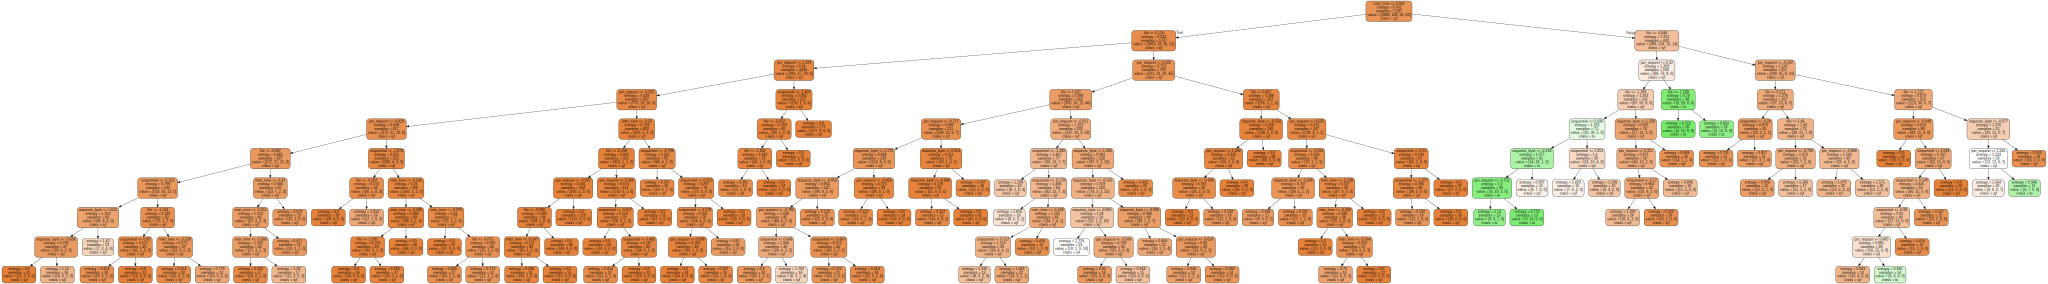

In [17]:
from graphviz import Source #用于绘制决策树的图像

with open("Tree.dot","r") as f:
    dot=f.read()
    
picture = Source(dot)
picture


In [18]:
#模型的其他属性
final_model.classes_

array([0, 1, 2, 3], dtype=int64)

In [19]:
final_model.get_params() #查看传入的所有参数

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 11,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'random'}